# Hyperparameter optimization

While model parameters are learnt during training hyperparameters must be set by the modeller before training. 
Hyperparameter tuning relies more on experimental results than theory, and thus the best method to determine the optimal settings is to try many different combinations evaluate the performance of each model.

In order to experiment with the parameters I will be using modified mushroom dataset. This dataset has 10 lakh rows and is extremely imbalanced. In this problem we need to classify whether the mushroom is edible or poisonous and as such we can see that false negatives are most dangerous, so recall will be the metric of choice.

Since its a classification problem I will use random forest classifier. The common hyperparameters for random forest are number of trees, tree depth, minimum samples at split and leaf & maximum number of predictors.


## Importing packages

In [147]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.preprocessing import LabelEncoder 
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

## Loading data & basic exploration

In [148]:
os.chdir(r'D:\DS\Machine learning\Datasets')
mush=pd.read_csv('datavswild.csv')

In [149]:
mush.head()

,safe,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,f,f,e,f,s,a,c,n,b,...,k,p,w,p,y,o,e,w,v,l
1,0,x,f,y,f,p,a,c,n,u,...,k,g,p,p,n,t,l,h,y,w
2,0,b,g,n,t,n,f,c,b,k,...,y,g,g,p,w,o,f,w,v,m
3,0,k,y,n,f,f,a,c,n,p,...,s,n,p,p,o,o,e,y,v,m
4,0,x,s,b,f,f,f,c,n,b,...,k,c,p,p,w,o,f,w,v,l


In [150]:
mush.shape

(1000000, 23)

In [151]:
mush.isna().sum()

safe                        0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [152]:
mush.drop_duplicates(inplace=True)

In [153]:
mush['safe'].value_counts()

0    995798
1      4159
Name: safe, dtype: int64

In [154]:
#Replacing all the single letter variable values with their full names
mush['cap-shape']=mush['cap-shape'].replace({'b':'bell','c':'conical','x':'convex','f':'flat','k':'knobbed','s':'sunken'})
mush['cap-surface']=mush['cap-surface'].replace({'f':'fibrous','g':'grooves','y':'scaly','s':'smooth'})
mush['cap-color']=mush['cap-color'].replace({'n':'brown','b':'buff','c':'cinnamon','g':'gray','r':'green' ,'p':'pink','u':'purple','e':'red','w':'white','y':'yellow'})
mush['bruises']=mush['bruises'].replace({'t':'bruises', 'f':'no bruises'})
mush['odor']=mush['odor'].replace({'a':'almond','l':'anise','c':'creosote','y':'fishy','f':'foul','m':'musty','n':'none','p':'pungent','s':'spicy'})
mush['gill-attachment']=mush['gill-attachment'].replace({'a':'attached','d':'descending','f':'free','n':'notched'})
mush['gill-spacing']=mush['gill-spacing'].replace({'c':'close','w':'crowded','d':'distant'})
mush['gill-size']=mush['gill-size'].replace({'b':'broad','n':'narrow'})
mush['gill-color']=mush['gill-color'].replace({'k':'black','n':'brown','b':'buff','h':'chocolate','g':'gray','r':'green','o':'orange','p':'pink','u':'purple','e':'red','w':'white','y':'yellow'})
mush['stalk-shape']=mush['stalk-shape'].replace({'e':'enlarging','t':'tapering'})
mush['stalk-root']=mush['stalk-root'].replace({'b':'bulbous','c':'club','u':'cup' ,'e':'equal','z':'rhizomorphs' ,'r':'rooted','m':'missing' })
mush['stalk-surface-above-ring']=mush['stalk-surface-above-ring'].replace({'f':'fibrous','y':'scaly','k':'silky','s':'smooth'})
mush['stalk-surface-below-ring']=mush['stalk-surface-below-ring'].replace({'f':'fibrous','y':'scaly','k':'silky','s':'smooth'})
mush['stalk-color-above-ring']=mush['stalk-color-above-ring'].replace({'n':'brown','b':'buff','c':'cinnamon','g':'gray','o':'orange','p':'pink','e':'red','w':'white','y':'yellow'})
mush['stalk-color-below-ring']=mush['stalk-color-below-ring'].replace({'n':'brown','b':'buff','c':'cinnamon','g':'gray','o':'orange','p':'pink','e':'red','w':'white','y':'yellow'})
mush['veil-color']=mush['veil-color'].replace({'n':'brown','o':'orange','w':'white','y':'yellow'})
mush['ring-number']=mush['ring-number'].replace({'n':'none','o':'one','t':'two'})
mush['ring-type']=mush['ring-type'].replace({'c':'cobwebby','e':'evanescent','f':'flaring','l':'large','n':'none','p':'pendant','s':'sheathing','z':'zone'})
mush['spore-print-color']=mush['spore-print-color'].replace({'k':'black','n':'brown','b':'buff','h':'chocolate','r':'green','o':'orange','u':'purple','w':'white','y':'yellow'})
mush['population']=mush['population'].replace({'a':'abundant','c':'clustered','n':'numerous','s':'scattered','v':'several','y':'solitary'})
mush['habitat']=mush['habitat'].replace({'g':'grasses','l':'leaves','m':'meadows','p':'paths','u':'urban','w':'waste','d':'woods'})

In [155]:
mush=pd.get_dummies(mush)

In [156]:
x=mush.drop('safe',axis=1)
y=mush['safe']

In [157]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: safe, dtype: int64

## Splitting data

In [158]:
xtrain,xval,ytrain,yval = train_test_split(x,y,shuffle=True,test_size=0.2)

In [159]:
xtrain,xtest,ytrain,ytest=train_test_split(xtrain,ytrain,test_size=0.25)

In [160]:
xtrain.head()

,cap-shape_bell,cap-shape_conical,cap-shape_convex,cap-shape_flat,cap-shape_knobbed,cap-shape_sunken,cap-surface_fibrous,cap-surface_grooves,cap-surface_scaly,cap-surface_smooth,...,population_scattered,population_several,population_solitary,habitat_grasses,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods
500439,0,0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
815997,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
79788,0,0,0,0,1,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
519976,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
428089,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0


## Decision tree

A basic decision tree is fitted on training data and its performance is checked on both training and validation data.

In [161]:
cl=DecisionTreeClassifier (criterion='gini',random_state=1,class_weight='balanced')
cl=cl.fit(xtrain,ytrain)

In [162]:
# Train data metrics
ytrainpred=cl.predict(xtrain)
print('Confusion matrix:\n',confusion_matrix(ytrain,ytrainpred))
print('Precision score:',metrics.precision_score(ytrain,ytrainpred))
print('Recall score:',metrics.recall_score(ytrain,ytrainpred))
print('ROC:',metrics.roc_auc_score(ytrain,ytrainpred))

Confusion matrix:
 [[597505      0]
 [     0   2468]]
Precision score: 1.0
Recall score: 1.0
ROC: 1.0


In [163]:
# Validation data metrics
ypred = cl.predict(xval)
print("Accuracy:",metrics.accuracy_score(yval,ypred))
print('Confusion matrix:\n',confusion_matrix(yval,ypred))
print('Precision score:',metrics.precision_score(yval,ypred))
print('Recall score:',metrics.recall_score(yval,ypred))
print('ROC:',metrics.roc_auc_score(yval,ypred))

Accuracy: 0.9921096843873755
Confusion matrix:
 [[198309    843]
 [   735    105]]
Precision score: 0.11075949367088607
Recall score: 0.125
ROC: 0.5603835261508797


We can see that the model fits the training data perfectly and thus leads to overfitting which can be observed by the metrics of validation data.

## Random Forest

In [164]:
# Basic random forest with default parameters
rf =RandomForestClassifier(n_jobs=-1,class_weight='balanced')
rf.fit(xtrain,ytrain)

D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [165]:
# Train data metrics
ypred=rf.predict(xtrain)
print('Confusion matrix:\n',confusion_matrix(ytrain,ypred))
print("Accuracy:",metrics.accuracy_score(ytrain,ypred))
print('Precision score:',metrics.precision_score(ytrain,ypred))
print('Recall score:',metrics.recall_score(ytrain,ypred))
print('ROC:',metrics.roc_auc_score(ytrain,ypred))

Confusion matrix:
 [[597505      0]
 [   552   1916]]
Accuracy: 0.9990799585981369
Precision score: 1.0
Recall score: 0.7763371150729336
ROC: 0.8881685575364668


In [166]:
# Test data metrics
ypred=rf.predict(xval)
print('Confusion matrix:\n',confusion_matrix(yval,ypred))
print("Accuracy:",metrics.accuracy_score(yval,ypred))
print('Precision score:',metrics.precision_score(yval,ypred))
print('Recall score:',metrics.recall_score(yval,ypred))
print('ROC:',metrics.roc_auc_score(yval,ypred))

Confusion matrix:
 [[199147      5]
 [   827     13]]
Accuracy: 0.9958398335933437
Precision score: 0.7222222222222222
Recall score: 0.015476190476190477
ROC: 0.5077255420124183


Random forest with default parameters didnt show improvement, in fact its worse than a single decision tree (w.r.t. recall).

### Number of trees

In [167]:
acctr=[]
pretr=[]
rectr=[]
roctr=[]
accval=[]
preval=[]
recval=[]
rocval=[]
trees=np.arange(50,1051,100)
for i in trees:
    rf = RandomForestClassifier(n_estimators = i,random_state=1,n_jobs=-1,class_weight='balanced')
    rf.fit(xtrain,ytrain)
    ypred=rf.predict(xtrain)
    acctr.append(metrics.accuracy_score(ytrain,ypred))
    pretr.append(metrics.precision_score(ytrain,ypred))
    rectr.append(metrics.recall_score(ytrain,ypred))
    roctr.append(metrics.roc_auc_score(ytrain,ypred))
    ypred=rf.predict(xval)
    accval.append(metrics.accuracy_score(yval,ypred))
    preval.append(metrics.precision_score(yval,ypred))
    recval.append(metrics.recall_score(yval,ypred))
    rocval.append(metrics.roc_auc_score(yval,ypred))

Text(0, 0.5, 'ROC')

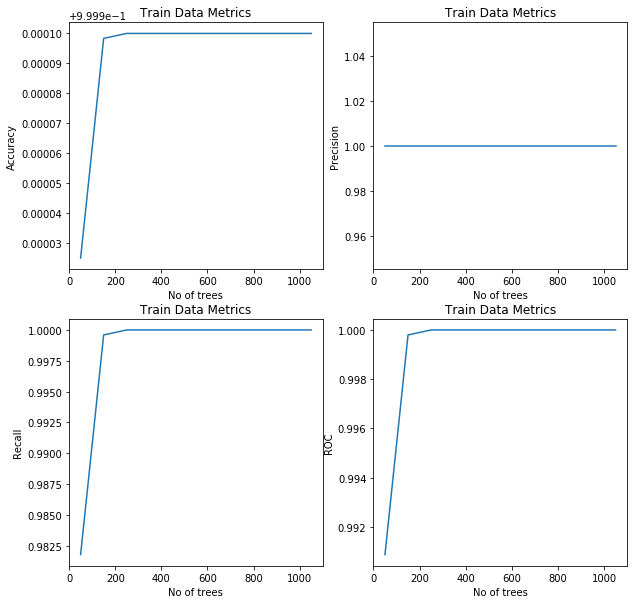

In [168]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Train Data Metrics')
plt.plot(trees,acctr)
plt.xlabel('No of trees')
plt.ylabel('Accuracy')
plt.subplot(2,2,2)
plt.title('Train Data Metrics')
plt.plot(trees,pretr)
plt.xlabel('No of trees')
plt.ylabel('Precision')
plt.subplot(2,2,3)
plt.title('Train Data Metrics')
plt.plot(trees,rectr)
plt.xlabel('No of trees')
plt.ylabel('Recall')
plt.subplot(2,2,4)
plt.title('Train Data Metrics')
plt.plot(trees,roctr)
plt.xlabel('No of trees')
plt.ylabel('ROC')

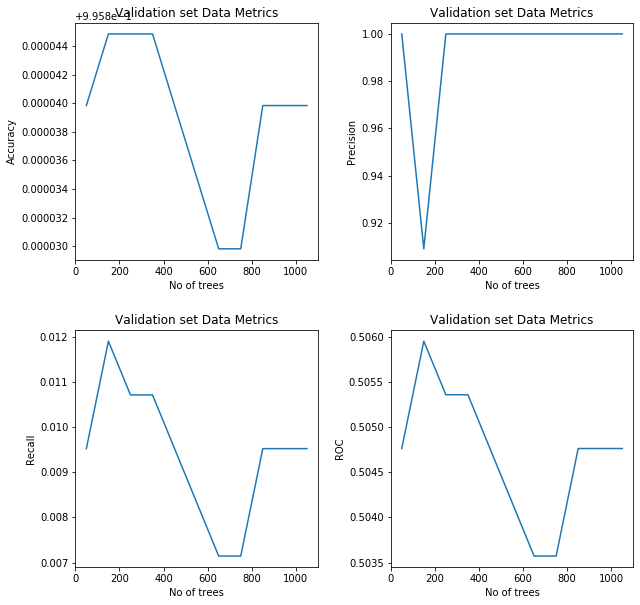

In [169]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Validation set Data Metrics')
plt.plot(trees,accval)
plt.xlabel('No of trees')
plt.ylabel('Accuracy')
plt.subplot(2,2,2)
plt.title('Validation set Data Metrics')
plt.plot(trees,preval)
plt.xlabel('No of trees')
plt.ylabel('Precision')
plt.subplot(2,2,3)
plt.title('Validation set Data Metrics')
plt.plot(trees,recval)
plt.xlabel('No of trees')
plt.ylabel('Recall')
plt.subplot(2,2,4)
plt.title('Validation set Data Metrics')
plt.plot(trees,rocval)
plt.xlabel('No of trees')
plt.ylabel('ROC')
plt.subplots_adjust(hspace=0.3,wspace=0.3)

For train data the number of trees after a certail level doesnt affect but for validation data it is seen that recall is not much affected by number of trees and the recall value remains very low.

### Max features

In [170]:
predictors=np.arange(1,118,2)
acctr=[]
pretr=[]
rectr=[]
roctr=[]
accval=[]
preval=[]
recval=[]
rocval=[]
for i in predictors:
    rf = RandomForestClassifier(max_features=i,random_state=1,n_jobs=-1,class_weight='balanced')
    rf.fit(xtrain,ytrain)
    ypred=rf.predict(xtrain)
    acctr.append(metrics.accuracy_score(ytrain,ypred))
    pretr.append(metrics.precision_score(ytrain,ypred))
    rectr.append(metrics.recall_score(ytrain,ypred))
    roctr.append(metrics.roc_auc_score(ytrain,ypred))
    ypred=rf.predict(xval)
    accval.append(metrics.accuracy_score(yval,ypred))
    preval.append(metrics.precision_score(yval,ypred))
    recval.append(metrics.recall_score(yval,ypred))
    rocval.append(metrics.roc_auc_score(yval,ypred))

D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The defaul

D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The de

Text(0, 0.5, 'ROC')

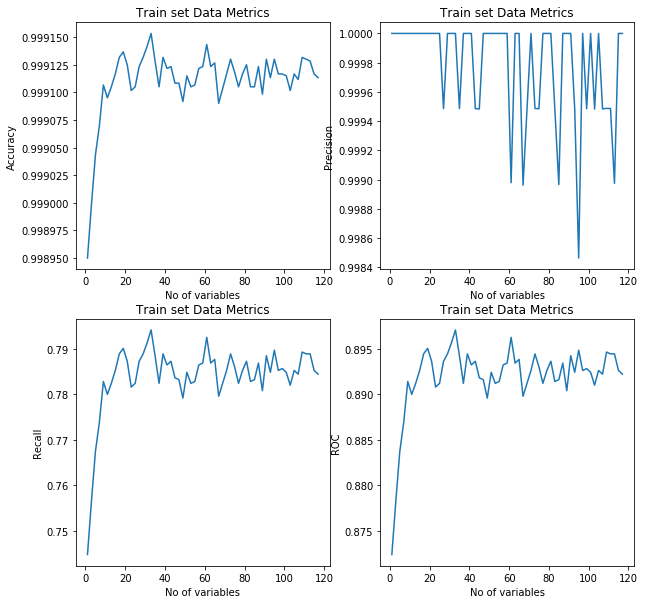

In [171]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Train set Data Metrics')
plt.plot(predictors,acctr)
plt.xlabel('No of variables')
plt.ylabel('Accuracy')
plt.subplot(2,2,2)
plt.title('Train set Data Metrics')
plt.plot(predictors,pretr)
plt.xlabel('No of variables')
plt.ylabel('Precision')
plt.subplot(2,2,3)
plt.title('Train set Data Metrics')
plt.plot(predictors,rectr)
plt.xlabel('No of variables')
plt.ylabel('Recall')
plt.subplot(2,2,4)
plt.title('Train set Data Metrics')
plt.plot(predictors,roctr)
plt.xlabel('No of variables')
plt.ylabel('ROC')

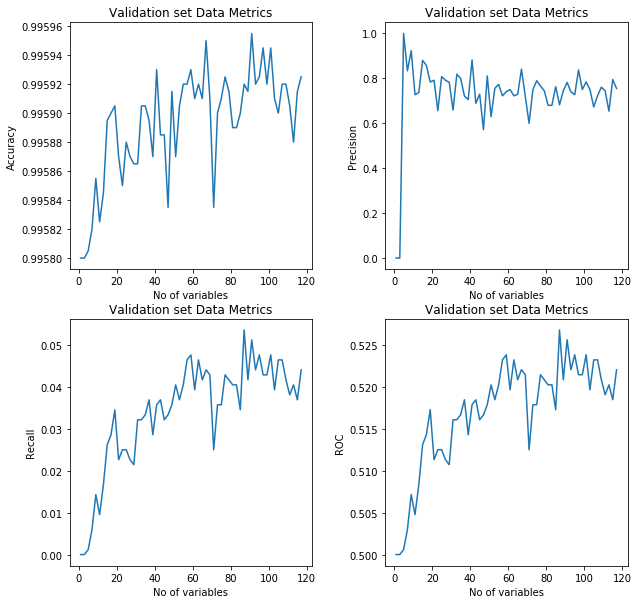

In [172]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Validation set Data Metrics')
plt.plot(predictors,accval)
plt.xlabel('No of variables')
plt.ylabel('Accuracy')
plt.subplot(2,2,2)
plt.title('Validation set Data Metrics')
plt.plot(predictors,preval)
plt.xlabel('No of variables')
plt.ylabel('Precision')
plt.subplot(2,2,3)
plt.title('Validation set Data Metrics')
plt.plot(predictors,recval)
plt.xlabel('No of variables')
plt.ylabel('Recall')
plt.subplot(2,2,4)
plt.title('Validation set Data Metrics')
plt.plot(predictors,rocval)
plt.xlabel('No of variables')
plt.ylabel('ROC')
plt.subplots_adjust(hspace=0.2,wspace=0.3)

As number of features available for classification increases it slightly increases our metrics but recall remains low.

### Tree Depth

In [173]:
depth=np.arange(10,101,10)
acctr=[]
pretr=[]
rectr=[]
roctr=[]
accval=[]
preval=[]
recval=[]
rocval=[]
for i in depth:
    rf = RandomForestClassifier(max_depth=i,random_state=1,n_jobs=-1,class_weight='balanced')
    rf.fit(xtrain,ytrain)
    ypred=rf.predict(xtrain)
    acctr.append(metrics.accuracy_score(ytrain,ypred))
    pretr.append(metrics.precision_score(ytrain,ypred))
    rectr.append(metrics.recall_score(ytrain,ypred))
    roctr.append(metrics.roc_auc_score(ytrain,ypred))
    ypred=rf.predict(xval)
    accval.append(metrics.accuracy_score(yval,ypred))
    preval.append(metrics.precision_score(yval,ypred))
    recval.append(metrics.recall_score(yval,ypred))
    rocval.append(metrics.roc_auc_score(yval,ypred))

D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The de

Text(0, 0.5, 'ROC')

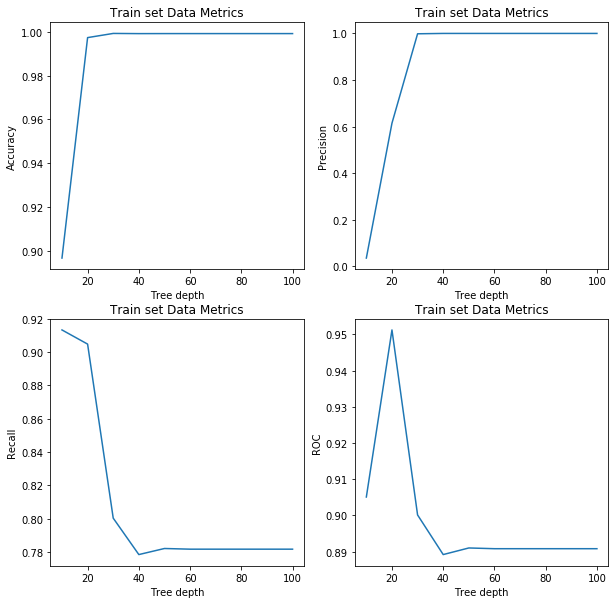

In [175]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Train set Data Metrics')
plt.plot(depth,acctr)
plt.xlabel('Tree depth')
plt.ylabel('Accuracy')
plt.subplot(2,2,2)
plt.title('Train set Data Metrics')
plt.plot(depth,pretr)
plt.xlabel('Tree depth')
plt.ylabel('Precision')
plt.subplot(2,2,3)
plt.title('Train set Data Metrics')
plt.plot(depth,rectr)
plt.xlabel('Tree depth')
plt.ylabel('Recall')
plt.subplot(2,2,4)
plt.title('Train set Data Metrics')
plt.plot(depth,roctr)
plt.xlabel('Tree depth')
plt.ylabel('ROC')

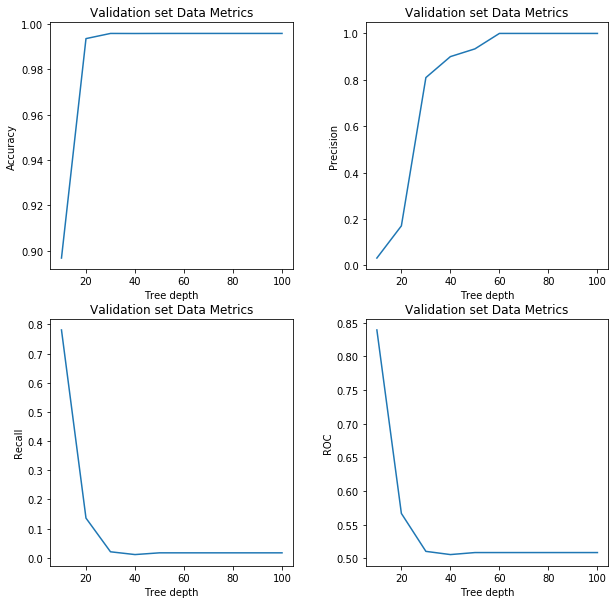

In [176]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Validation set Data Metrics')
plt.plot(depth,accval)
plt.xlabel('Tree depth')
plt.ylabel('Accuracy')
plt.subplot(2,2,2)
plt.title('Validation set Data Metrics')
plt.plot(depth,preval)
plt.xlabel('Tree depth')
plt.ylabel('Precision')
plt.subplot(2,2,3)
plt.title('Validation set Data Metrics')
plt.plot(depth,recval)
plt.xlabel('Tree depth')
plt.ylabel('Recall')
plt.subplot(2,2,4)
plt.title('Validation set Data Metrics')
plt.plot(depth,rocval)
plt.xlabel('Tree depth')
plt.ylabel('ROC')
plt.subplots_adjust(hspace=0.2,wspace=0.3)

As tree depth increases there is a loss in recall until it stablizes even for train data. Similar trend is visible in validation set. It can be seen that recall starts off at a very high value suggesting that short trees is better for our problem.

### Minimum Sample to Split

In [177]:
sampspl=np.arange(5,50,5)
acctr=[]
pretr=[]
rectr=[]
roctr=[]
accval=[]
preval=[]
recval=[]
rocval=[]
for i in sampspl:
    rf = RandomForestClassifier(min_samples_split=i,random_state=1,n_jobs=-1,class_weight='balanced')
    rf.fit(xtrain,ytrain)
    ypred=rf.predict(xtrain)
    acctr.append(metrics.accuracy_score(ytrain,ypred))
    pretr.append(metrics.precision_score(ytrain,ypred))
    rectr.append(metrics.recall_score(ytrain,ypred))
    roctr.append(metrics.roc_auc_score(ytrain,ypred))
    ypred=rf.predict(xval)
    accval.append(metrics.accuracy_score(yval,ypred))
    preval.append(metrics.precision_score(yval,ypred))
    recval.append(metrics.recall_score(yval,ypred))
    rocval.append(metrics.roc_auc_score(yval,ypred))

D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The de

Text(0, 0.5, 'ROC')

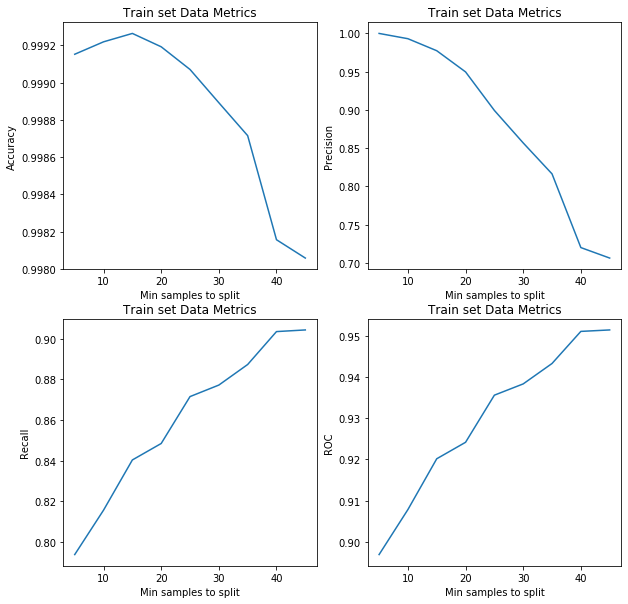

In [178]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Train set Data Metrics')
plt.plot(sampspl,acctr)
plt.xlabel('Min samples to split')
plt.ylabel('Accuracy')
plt.subplot(2,2,2)
plt.title('Train set Data Metrics')
plt.plot(sampspl,pretr)
plt.xlabel('Min samples to split')
plt.ylabel('Precision')
plt.subplot(2,2,3)
plt.title('Train set Data Metrics')
plt.plot(sampspl,rectr)
plt.xlabel('Min samples to split')
plt.ylabel('Recall')
plt.subplot(2,2,4)
plt.title('Train set Data Metrics')
plt.plot(sampspl,roctr)
plt.xlabel('Min samples to split')
plt.ylabel('ROC')

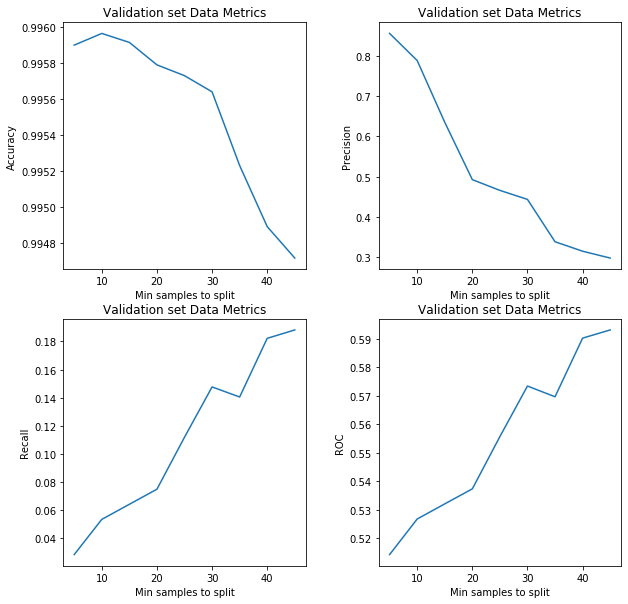

In [179]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Validation set Data Metrics')
plt.plot(sampspl,accval)
plt.xlabel('Min samples to split')
plt.ylabel('Accuracy')
plt.subplot(2,2,2)
plt.title('Validation set Data Metrics')
plt.plot(sampspl,preval)
plt.xlabel('Min samples to split')
plt.ylabel('Precision')
plt.subplot(2,2,3)
plt.title('Validation set Data Metrics')
plt.plot(sampspl,recval)
plt.xlabel('Min samples to split')
plt.ylabel('Recall')
plt.subplot(2,2,4)
plt.title('Validation set Data Metrics')
plt.plot(sampspl,rocval)
plt.xlabel('Min samples to split')
plt.ylabel('ROC')
plt.subplots_adjust(hspace=0.2,wspace=0.3)

We can see that as we increase the minimum sample to be available at a split the recall improves. Higher values can increase recall.

### Minimum samples in leaf

In [180]:
sampleaf=np.arange(1,31,1)
acctr=[]
pretr=[]
rectr=[]
roctr=[]
accval=[]
preval=[]
recval=[]
rocval=[]
for i in sampleaf:
    rf = RandomForestClassifier(min_samples_leaf=i,random_state=1,n_jobs=-1,class_weight='balanced')
    rf.fit(xtrain,ytrain)
    ypred=rf.predict(xtrain)
    acctr.append(metrics.accuracy_score(ytrain,ypred))
    pretr.append(metrics.precision_score(ytrain,ypred))
    rectr.append(metrics.recall_score(ytrain,ypred))
    roctr.append(metrics.roc_auc_score(ytrain,ypred))
    ypred=rf.predict(xval)
    accval.append(metrics.accuracy_score(yval,ypred))
    preval.append(metrics.precision_score(yval,ypred))
    recval.append(metrics.recall_score(yval,ypred))
    rocval.append(metrics.roc_auc_score(yval,ypred))

D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The de

Text(0, 0.5, 'ROC')

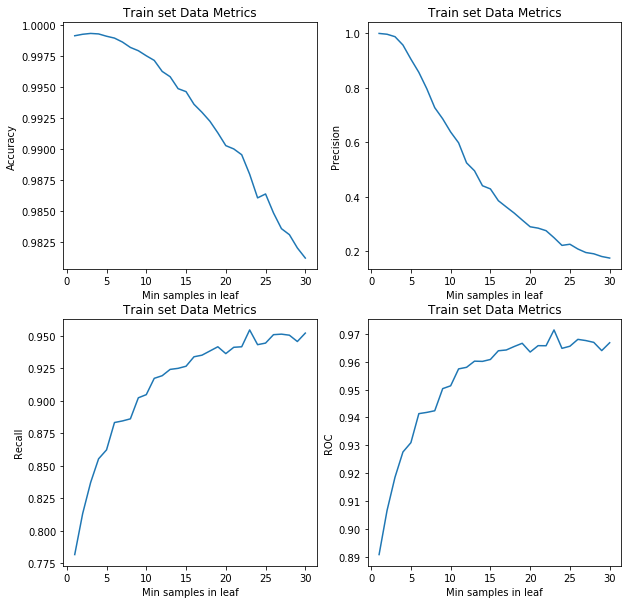

In [181]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Train set Data Metrics')
plt.plot(sampleaf,acctr)
plt.xlabel('Min samples in leaf')
plt.ylabel('Accuracy')
plt.subplot(2,2,2)
plt.title('Train set Data Metrics')
plt.plot(sampleaf,pretr)
plt.xlabel('Min samples in leaf')
plt.ylabel('Precision')
plt.subplot(2,2,3)
plt.title('Train set Data Metrics')
plt.plot(sampleaf,rectr)
plt.xlabel('Min samples in leaf')
plt.ylabel('Recall')
plt.subplot(2,2,4)
plt.title('Train set Data Metrics')
plt.plot(sampleaf,roctr)
plt.xlabel('Min samples in leaf')
plt.ylabel('ROC')

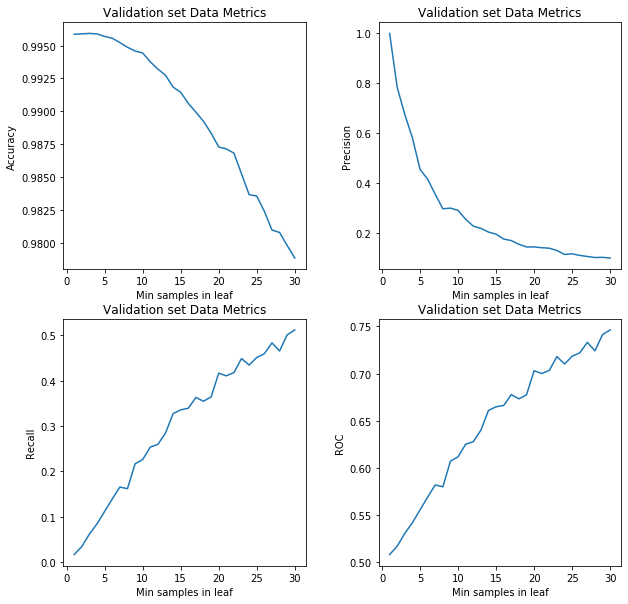

In [182]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Validation set Data Metrics')
plt.plot(sampleaf,accval)
plt.xlabel('Min samples in leaf')
plt.ylabel('Accuracy')
plt.subplot(2,2,2)
plt.title('Validation set Data Metrics')
plt.plot(sampleaf,preval)
plt.xlabel('Min samples in leaf')
plt.ylabel('Precision')
plt.subplot(2,2,3)
plt.title('Validation set Data Metrics')
plt.plot(sampleaf,recval)
plt.xlabel('Min samples in leaf')
plt.ylabel('Recall')
plt.subplot(2,2,4)
plt.title('Validation set Data Metrics')
plt.plot(sampleaf,rocval)
plt.xlabel('Min samples in leaf')
plt.ylabel('ROC')
plt.subplots_adjust(hspace=0.2,wspace=0.3)

Minimum samples in leaf behaves similar to minimum samples to split criteria and recall increases as we increase minimum in leaf.

## Combinations

### Combination 1- Min samples at leaf-2, Max depth-10, Mins samples at split-10, No of trees-200, Max features-50

In [202]:
acctr=[]
pretr=[]
rectr=[]
roctr=[]
accval=[]
preval=[]
recval=[]
rocval=[]
rf = RandomForestClassifier(min_samples_leaf=2,max_depth=10,min_samples_split=10,n_estimators=200,max_features=50,random_state=1,n_jobs=4,class_weight='balanced')
rf.fit(xtrain,ytrain)
ypred=rf.predict(xtrain)
acctr.append(metrics.accuracy_score(ytrain,ypred))
pretr.append(metrics.precision_score(ytrain,ypred))
rectr.append(metrics.recall_score(ytrain,ypred))
roctr.append(metrics.roc_auc_score(ytrain,ypred))
ypred=rf.predict(xval)
accval.append(metrics.accuracy_score(yval,ypred))
preval.append(metrics.precision_score(yval,ypred))
recval.append(metrics.recall_score(yval,ypred))
rocval.append(metrics.roc_auc_score(yval,ypred))

In [203]:
# Train set metrics
ypred=rf.predict(xtrain)
print('Confusion matrix:\n',confusion_matrix(ytrain,ypred))
print("Accuracy:",metrics.accuracy_score(ytrain,ypred))
print('Precision score:',metrics.precision_score(ytrain,ypred))
print('Recall score:',metrics.recall_score(ytrain,ypred))
print('ROC:',metrics.roc_auc_score(ytrain,ypred))

Confusion matrix:
 [[547560  49945]
 [   181   2287]]
Accuracy: 0.9164529070474838
Precision score: 0.04378541890029101
Recall score: 0.9266612641815235
ROC: 0.921536002757116


In [204]:
# Validation set metrics
ypred=rf.predict(xval)
print('Confusion matrix:\n',confusion_matrix(yval,ypred))
print("Accuracy:",metrics.accuracy_score(yval,ypred))
print('Precision score:',metrics.precision_score(yval,ypred))
print('Recall score:',metrics.recall_score(yval,ypred))
print('ROC:',metrics.roc_auc_score(yval,ypred))

Confusion matrix:
 [[182613  16539]
 [   210    630]]
Accuracy: 0.9162516500660026
Precision score: 0.03669404158658046
Recall score: 0.75
ROC: 0.8334764401060497


We get a decent recall and ROC score by having a small depth.

### Combination 2- Min samples at leaf-30, Max depth-40, Mins samples at split-50, No of trees-200, Max features-50

In [205]:
acctr=[]
pretr=[]
rectr=[]
roctr=[]
accval=[]
preval=[]
recval=[]
rocval=[]
rf = RandomForestClassifier(min_samples_leaf=30,max_depth=40,min_samples_split=50,n_estimators=200,max_features=50,random_state=1,n_jobs=4,class_weight='balanced')
rf.fit(xtrain,ytrain)
ypred=rf.predict(xtrain)
acctr.append(metrics.accuracy_score(ytrain,ypred))
pretr.append(metrics.precision_score(ytrain,ypred))
rectr.append(metrics.recall_score(ytrain,ypred))
roctr.append(metrics.roc_auc_score(ytrain,ypred))
ypred=rf.predict(xval)
accval.append(metrics.accuracy_score(yval,ypred))
preval.append(metrics.precision_score(yval,ypred))
recval.append(metrics.recall_score(yval,ypred))
rocval.append(metrics.roc_auc_score(yval,ypred))

In [206]:
# Train set metrics
ypred=rf.predict(xtrain)
print('Confusion matrix:\n',confusion_matrix(ytrain,ypred))
print("Accuracy:",metrics.accuracy_score(ytrain,ypred))
print('Precision score:',metrics.precision_score(ytrain,ypred))
print('Recall score:',metrics.recall_score(ytrain,ypred))
print('ROC:',metrics.roc_auc_score(ytrain,ypred))

Confusion matrix:
 [[590968   6537]
 [     4   2464]]
Accuracy: 0.9890978427362564
Precision score: 0.2737473614042884
Recall score: 0.9983792544570502
ROC: 0.9937193801176223


In [207]:
# Validation set metrics
ypred=rf.predict(xval)
print('Confusion matrix:\n',confusion_matrix(yval,ypred))
print("Accuracy:",metrics.accuracy_score(yval,ypred))
print('Precision score:',metrics.precision_score(yval,ypred))
print('Recall score:',metrics.recall_score(yval,ypred))
print('ROC:',metrics.roc_auc_score(yval,ypred))

Confusion matrix:
 [[196864   2288]
 [   457    383]]
Accuracy: 0.9862744509780391
Precision score: 0.14339198801946837
Recall score: 0.45595238095238094
ROC: 0.7222318344064548


Scores are not as good as before.

### Combination 3- Min samples at leaf-50, Max depth-20, Mins samples at split-40, No of trees-200, Max features-50

In [208]:
acctr=[]
pretr=[]
rectr=[]
roctr=[]
accval=[]
preval=[]
recval=[]
rocval=[]
rf = RandomForestClassifier(min_samples_leaf=50,max_depth=20,min_samples_split=40,n_estimators=200,max_features=60,random_state=1,n_jobs=-1,class_weight='balanced')
rf.fit(xtrain,ytrain)
ypred=rf.predict(xtrain)
acctr.append(metrics.accuracy_score(ytrain,ypred))
pretr.append(metrics.precision_score(ytrain,ypred))
rectr.append(metrics.recall_score(ytrain,ypred))
roctr.append(metrics.roc_auc_score(ytrain,ypred))
ypred=rf.predict(xval)
accval.append(metrics.accuracy_score(yval,ypred))
preval.append(metrics.precision_score(yval,ypred))
recval.append(metrics.recall_score(yval,ypred))
rocval.append(metrics.roc_auc_score(yval,ypred))

In [209]:
# Train set metrics
ypred=rf.predict(xtrain)
print('Confusion matrix:\n',confusion_matrix(ytrain,ypred))
print("Accuracy:",metrics.accuracy_score(ytrain,ypred))
print('Precision score:',metrics.precision_score(ytrain,ypred))
print('Recall score:',metrics.recall_score(ytrain,ypred))
print('ROC:',metrics.roc_auc_score(ytrain,ypred))

Confusion matrix:
 [[583514  13991]
 [    15   2453]]
Accuracy: 0.9766556161693943
Precision score: 0.14917295062028704
Recall score: 0.9939222042139384
ROC: 0.9852532502898296


In [210]:
# Validation set metrics
ypred=rf.predict(xval)
print('Confusion matrix:\n',confusion_matrix(yval,ypred))
print("Accuracy:",metrics.accuracy_score(yval,ypred))
print('Precision score:',metrics.precision_score(yval,ypred))
print('Recall score:',metrics.recall_score(yval,ypred))
print('ROC:',metrics.roc_auc_score(yval,ypred))

Confusion matrix:
 [[194417   4735]
 [   359    481]]
Accuracy: 0.9745289811592464
Precision score: 0.09221625766871165
Recall score: 0.5726190476190476
ROC: 0.7744216190935279


The scores are not as good as before.

### Combination 4- Min samples at leaf-40, Max depth-10, Mins samples at split-60, No of trees-200, Max features-50

In [212]:
acctr=[]
pretr=[]
rectr=[]
roctr=[]
accval=[]
preval=[]
recval=[]
rocval=[]
rf = RandomForestClassifier(min_samples_leaf=40,max_depth=10,min_samples_split=60,n_estimators=200,max_features=60,random_state=1,n_jobs=-1,class_weight='balanced')
rf.fit(xtrain,ytrain)
ypred=rf.predict(xtrain)
acctr.append(metrics.accuracy_score(ytrain,ypred))
pretr.append(metrics.precision_score(ytrain,ypred))
rectr.append(metrics.recall_score(ytrain,ypred))
roctr.append(metrics.roc_auc_score(ytrain,ypred))
ypred=rf.predict(xval)
accval.append(metrics.accuracy_score(yval,ypred))
preval.append(metrics.precision_score(yval,ypred))
recval.append(metrics.recall_score(yval,ypred))
rocval.append(metrics.roc_auc_score(yval,ypred))

In [213]:
# Train set metrics
ypred=rf.predict(xtrain)
print('Confusion matrix:\n',confusion_matrix(ytrain,ypred))
print("Accuracy:",metrics.accuracy_score(ytrain,ypred))
print('Precision score:',metrics.precision_score(ytrain,ypred))
print('Recall score:',metrics.recall_score(ytrain,ypred))
print('ROC:',metrics.roc_auc_score(ytrain,ypred))

Confusion matrix:
 [[546137  51368]
 [   198   2270]]
Accuracy: 0.9140527990426236
Precision score: 0.04232074275700064
Recall score: 0.919773095623987
ROC: 0.9169011334639965


In [214]:
# Validation set metrics
ypred=rf.predict(xval)
print('Confusion matrix:\n',confusion_matrix(yval,ypred))
print("Accuracy:",metrics.accuracy_score(yval,ypred))
print('Precision score:',metrics.precision_score(yval,ypred))
print('Recall score:',metrics.recall_score(yval,ypred))
print('ROC:',metrics.roc_auc_score(yval,ypred))

Confusion matrix:
 [[182183  16969]
 [   198    642]]
Accuracy: 0.9141615664626586
Precision score: 0.03645448867185282
Recall score: 0.7642857142857142
ROC: 0.839539719840696


The scores are pretty similar to our first combination which suggests that tree depth is the criteria controlling the score. A decent recall and ROC score while having a bad precision.  But for our problem a good recall score is more important. This combination of parameters gives us the best result of the 4.

In [215]:
# Test set metrics
ypred=rf.predict(xtest)
print('Confusion matrix:\n',confusion_matrix(ytest,ypred))
print("Accuracy:",metrics.accuracy_score(ytest,ypred))
print('Precision score:',metrics.precision_score(ytest,ypred))
print('Recall score:',metrics.recall_score(ytest,ypred))
print('ROC:',metrics.roc_auc_score(ytest,ypred))

Confusion matrix:
 [[181847  17294]
 [   203    648]]
Accuracy: 0.9125115004600184
Precision score: 0.036116374986066214
Recall score: 0.7614571092831962
ROC: 0.8373070593191885


A similar score is encountered in our test dataset for the chosen model.

## Conclusion

We saw that we can tune hyper parameters to tailor the model to our needs. Initially it was predicting everything as non posionous and that earned a big accuracy score because of the imbalance in data. Once we started tuning the parameters we lost a bit of accuracy but achieved a decent recall score.

A better way would be to use grid search or random search but these are computationally expensive and even 27 combinations of the parameters wasnt being fitted in 3 hours on this dataset.